# Allen-Cahn equation

In [1]:
import sys
import os
sys.path.append("./src")

In [2]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *

### Setup

In [3]:
# Exact solution

def exactAC(x, t):
    '''
    Args:
        x: jnp.array, points in space
        t: jnp.array (or float), points in time
    '''
    raise NotImplementedError

In [30]:
# Problem and training data

phi = lambda x, w, b: jnp.exp(- w ** 2 * jnp.abs(jnp.sin(jnp.pi * (x - b) / (2 * jnp.pi))) ** 2)
u0 = lambda x: phi(x, jnp.sqrt(10), 0.5) - phi(x, jnp.sqrt(10), 4.4)

problem_data = ProblemData(name='ac', # problem name
                           d=1, # input dimension
                           domain=(0, 2 * jnp.pi), # 1D: (lower, upper)
                           T=12, # final time
                           initial_fn=u0, # initial condition
                           exact_sol=None, # exact solution
                           N=2048, # number of spatial points
                           dt=0.01, # time step
                          )

training_data = TrainingData(m=10, # number of neurons per layer
                             l=1, # number of layers
                             batch_size=1000, # batch size
                             epochs=10000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             # scheduler=optax.exponential_decay(init_value=0.1, transition_steps=10000, decay_rate=0.9) # learning rate scheduler
                             scheduler=optax.linear_schedule(init_value=0.1, end_value=0.001, 
                                                             transition_steps=1000, transition_begin=1000) # learning rate scheduler
                             # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                             #scheduler=optax.cosine_decay_schedule(init_value=0.1, decay_steps=1000) # learning rate scheduler
                            )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


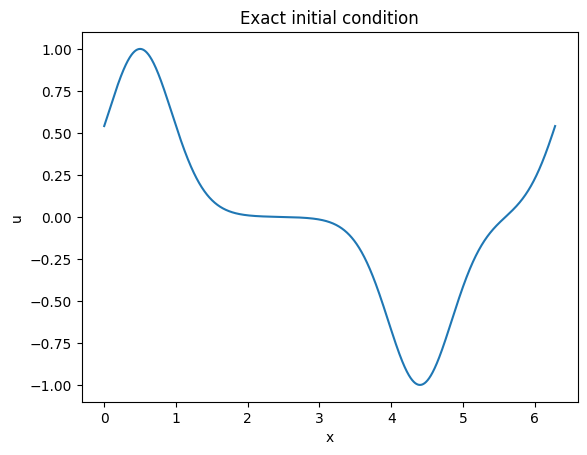

In [5]:
plot_function(problem_data.initial_fn, problem_data, 'Exact initial condition')

In [6]:
print(problem_data)

Problem data:
  name: ac, d: 1, domain: (0, 6.283185307179586), T: 12, N: 2048, dt: 0.01


In [7]:
print(training_data)

Training data:
  m: 10, l: 1, batch size: 1000, epochs: 10000, gamma: 0.1, seed: 0, scheduler: <function polynomial_schedule.<locals>.schedule at 0x7f70e462dd00>


### Initial fit

In [32]:
# Neural network

net = DeepNetAC(training_data.m, training_data.l, problem_data.domain[1] - problem_data.domain[0])
print(net)

DeepNetAC(
    # attributes
    m = 10
    l = 1
    L = 6.283185307179586
)


In [33]:
# Initial fit

initial_fit = False # True to train a NN to fit the initial condition, False otherwise

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_m' + str(training_data.m) + '_l' + str(training_data.l) + '_' + str(training_data.seed) + '.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '_m' + str(training_data.m) + '_l' + str(training_data.l) + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item()
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N).reshape(-1, 1)
    relative_error = jnp.linalg.norm(net.apply(theta, x_plot.reshape(-1, 1)) - u0(x_plot)) / jnp.linalg.norm(u0(x_plot))
    print("Relative error of the initial fit:", relative_error)

Relative error of the initial fit: 0.004191221


### Time evolution

In [27]:
# Source term for the AC equation

def rhs_ac(theta_flat, x, t, u_fn):
    epsilon = 5e-2
    a = lambda x, t: (1.05 + t * jnp.sin(x)).squeeze()
    U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
    U_ddx = jax.vmap(gradsqz(gradsqz(u_fn, 1), 1), (None, 0))
    u = U(theta, x)
    u_xx = U_ddx(theta, x)
    return epsilon * u_xx - a(x, t) * (u - u ** 3)

In [28]:
# @jax.jit
# def r_loss(theta_flat, theta_flat_k, x, t):
#     '''
#     Compute the norm of the residual.
#     '''
#     return jnp.linalg.norm(r_fn(theta_flat, theta_flat_k, x, t))

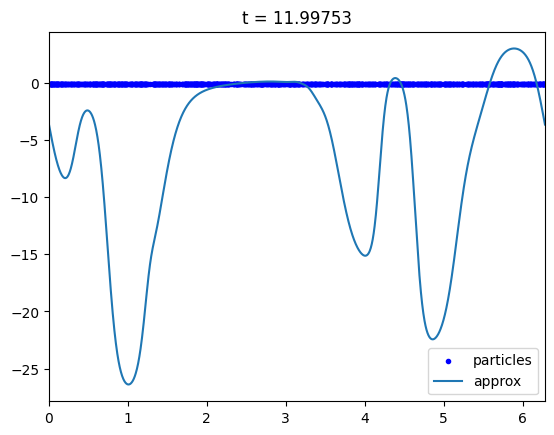

In [34]:
solution, timesteps, _ = neural_galerkin(theta=theta, # initial parameters
                                         net=net, # neural network
                                         problem_data=problem_data, # problem data
                                         n=1000, # sample points
                                         rhs=rhs_ac, # problem RHS
                                         x_init=None,
                                         sampler='uniform',
                                         scheme='rk45'
                                        )

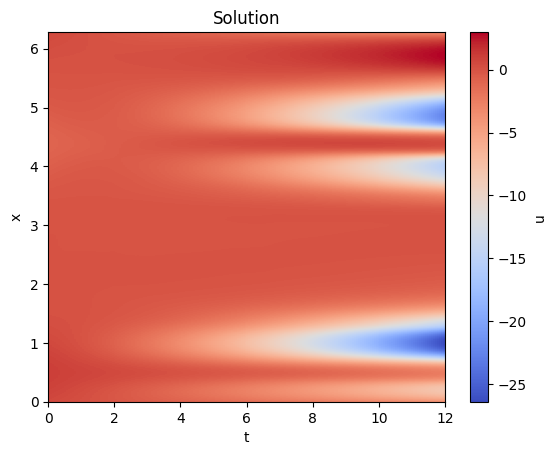

In [35]:
plot_solution(solution, timesteps, problem_data)

In [ ]:
# plot_animation(solution, timesteps, problem_data)

### Compute relative error

In [15]:
# errors = compute_error(solution, timesteps, exactAC, problem_data)

In [ ]:
# plot_error(errors, timesteps, 'Relative L2 error for NG')

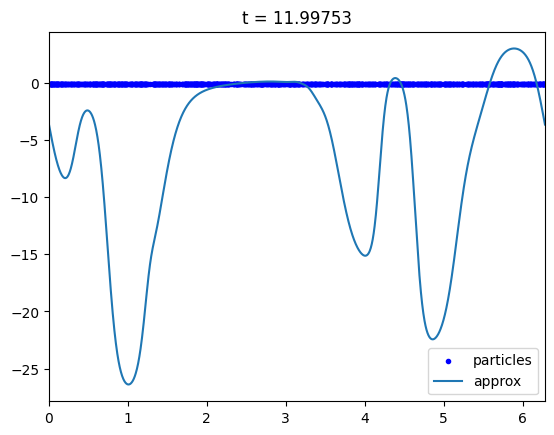

In [36]:
solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                  net=net, # neural network
                                                  problem_data=problem_data, # problem data
                                                  n=1000, # sample points
                                                  rhs=rhs_ac, # problem RHS
                                                  x_init=None,
                                                  sampler='uniform',
                                                  scheme='rk45',
                                                  diagnostic_on=True # save conditioning number and singular values of the mass matrix
                                                 )

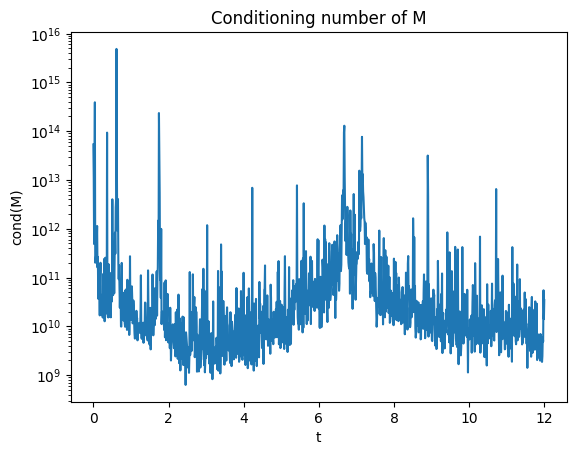

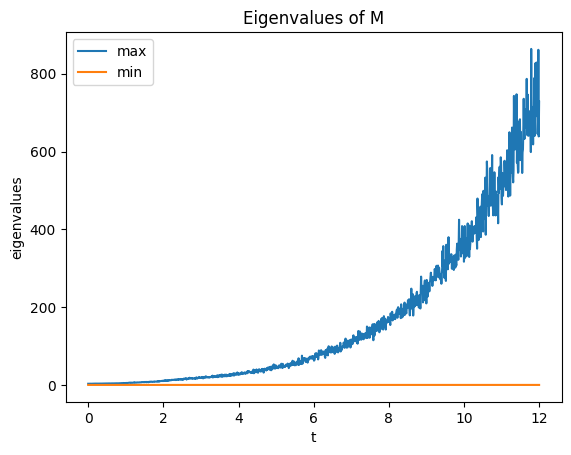

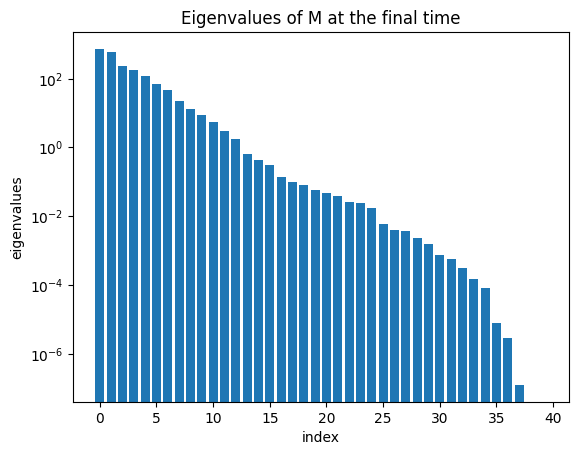

In [37]:
diagnostic.plot(timesteps)